In [134]:
import re
from pathlib import Path
from pprint import pp

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (
    PredictionErrorDisplay,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from P04_ml.T00_lib.classes import MyUtil
from P04_ml.T00_lib.utils import check_jupyter


In [135]:
SAVE_DATA = False
MAKE_ONE_HOT = True

In [136]:
if check_jupyter():
    BASE_DIR = Path.cwd()  # Current directory of the running file
    DATA_DIR = BASE_DIR.parent.parent / "P03_data_preprocess"
    CURRENT_DIR = BASE_DIR
else:
    BASE_DIR = Path.cwd()  # Base directory of the project
    DATA_DIR = BASE_DIR / "src/P03_data_preprocess"
    CURRENT_DIR = Path(__file__).resolve().parent

dt = MyUtil.get_dt()
print(f"Current Directory: {CURRENT_DIR}")
print(f"Current Date and Time: {dt}")

# Load data
df = pd.read_excel(DATA_DIR / "S07_data_combined_loc.xlsx")
print(df.shape)
df

Code is running in a Jupyter environment.
Current Directory: c:\Users\admin\Coding\research\weld-ml\src\P04_ml\T01_ml_trial
Current Date and Time: 2026-01-04_07-50
(378, 183)


,sample_no,R,W,D,position,location,fz_location,"dwell_Fz__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""max""",dwell_Fz__mean_change,"dwell_Fz__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.0",...,"weld_Fz__fft_coefficient__attr_""angle""__coeff_26","weld_Fz__fft_coefficient__attr_""angle""__coeff_86","weld_Fz__change_quantiles__f_agg_""mean""__isabs_False__qh_0.6__ql_0.2","weld_Fz__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.2",weld_Fz__ratio_beyond_r_sigma__r_2.5,weld_Fz__binned_entropy__max_bins_10,weld_Fz__kurtosis,stress_value_5052,stress_value_6061,stress_value_center
0,1,1400,60,10,0.153846,1,1.244326,-0.015598,-0.000466,-0.000466,...,-59.307464,-126.394608,0.000592,0.000077,0.011999,1.996898,0.031761,28,51,12
1,2,1400,60,15,0.153846,1,1.203367,-0.001207,-0.000060,-0.000060,...,-67.104324,-83.441169,0.001515,0.000074,0.026536,1.433742,2.139541,14,-21,17
2,3,1400,60,20,0.153846,1,1.444542,-0.004830,-0.000198,-0.000198,...,-73.946166,-100.226178,0.002915,0.000764,0.046766,1.651073,1.957977,10,35,12
3,4,1400,70,10,0.153846,1,1.601667,-0.012681,-0.000459,-0.000459,...,-109.557287,-92.120362,-0.002131,-0.000669,0.032843,1.331185,3.615244,10,-10,20
4,5,1400,70,15,0.153846,1,1.095031,-0.028589,-0.000819,-0.000819,...,142.508379,101.664911,0.005496,0.000705,0.017408,1.739714,-0.003368,6,41,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,50,1600,70,15,0.846154,7,1.905742,-0.025181,-0.000835,-0.000835,...,100.417769,70.734310,-0.000276,0.000027,0.012383,2.073254,-0.284814,4,-23,2
374,51,1600,70,20,0.846154,7,1.669120,-0.019329,-0.000656,-0.000656,...,77.002325,105.356086,0.002244,0.000891,0.000090,2.110911,-0.807980,0,-1,2
375,52,1600,80,10,0.846154,7,1.671576,-0.034536,-0.000915,-0.000915,...,-114.510109,160.581335,0.002110,0.000548,0.011999,1.947229,-0.492903,-2,-41,5
376,53,1600,80,15,0.846154,7,1.686495,-0.060666,-0.001356,-0.001356,...,49.909992,-131.625465,0.003661,0.001454,0.042150,1.607697,1.674617,10,-90,1


In [137]:
colsY = [c for c in df.columns if re.search(r"stress_value", c)]
print(colsY)
colsX = [c for c in df.columns if c not in colsY]
print(colsX)

['stress_value_5052', 'stress_value_6061', 'stress_value_center']
['sample_no', 'R', 'W', 'D', 'position', 'location', 'fz_location', 'dwell_Fz__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'dwell_Fz__mean_change', 'dwell_Fz__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0', 'dwell_Fz__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'dwell_Fz__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'dwell_Fz__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6', 'dwell_Fz__fft_coefficient__attr_"real"__coeff_59', 'dwell_Fz__fft_coefficient__attr_"real"__coeff_4', 'dwell_Fz__fft_coefficient__attr_"real"__coeff_71', 'dwell_Fz__partial_autocorrelation__lag_7', 'dwell_Fz__symmetry_looking__r_0.05', 'dwell_Fz__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'dwell_Fz__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'dwell_Fz__fft_coefficient__attr_"angle"__coeff_4', 'dwell_Fz__binned_entropy__max_bins_10', '

In [138]:
dfY = df[colsY]
dfX_all = df[colsX]

In [139]:
if MAKE_ONE_HOT:
    dft1 = pd.get_dummies(dfX_all, columns=["location", "R", "W", "D"], drop_first=False, dtype=int)
    dfX = dft1.drop(columns=["sample_no"])    
else:
    dfX = dfX_all.drop(columns=["sample_no", "location"])
dfX

,position,fz_location,"dwell_Fz__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""max""",dwell_Fz__mean_change,"dwell_Fz__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.0","dwell_Fz__change_quantiles__f_agg_""mean""__isabs_False__qh_0.8__ql_0.0","dwell_Fz__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""","dwell_Fz__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.6","dwell_Fz__fft_coefficient__attr_""real""__coeff_59","dwell_Fz__fft_coefficient__attr_""real""__coeff_4",...,location_7,R_1400,R_1500,R_1600,W_60,W_70,W_80,D_10,D_15,D_20
0,0.153846,1.244326,-0.015598,-0.000466,-0.000466,0.001578,0.003409,0.054540,0.549447,10.030128,...,0,1,0,0,1,0,0,1,0,0
1,0.153846,1.203367,-0.001207,-0.000060,-0.000060,-0.000243,0.002961,0.066685,0.206725,20.182526,...,0,1,0,0,1,0,0,0,1,0
2,0.153846,1.444542,-0.004830,-0.000198,-0.000198,-0.000230,0.004525,0.054354,0.510514,11.442374,...,0,1,0,0,1,0,0,0,0,1
3,0.153846,1.601667,-0.012681,-0.000459,-0.000459,-0.001317,0.004067,0.058211,0.276479,3.854696,...,0,1,0,0,0,1,0,1,0,0
4,0.153846,1.095031,-0.028589,-0.000819,-0.000819,-0.000218,0.000968,0.055285,2.506562,24.440018,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,0.846154,1.905742,-0.025181,-0.000835,-0.000835,-0.000263,0.003179,0.069095,0.583809,19.669345,...,1,0,0,1,0,1,0,0,1,0
374,0.846154,1.669120,-0.019329,-0.000656,-0.000656,-0.000664,0.003283,0.070212,1.004801,25.757752,...,1,0,0,1,0,1,0,0,0,1
375,0.846154,1.671576,-0.034536,-0.000915,-0.000915,-0.000276,0.002971,0.072483,0.596623,20.616756,...,1,0,0,1,0,0,1,1,0,0
376,0.846154,1.686495,-0.060666,-0.001356,-0.001356,-0.001039,0.005970,0.094026,0.938319,14.936861,...,1,0,0,1,0,0,1,0,1,0


In [140]:
# Extract features and targets
_X = dfX.values
_Y = dfY.values

print(_X.shape)
print(_Y.shape)

(378, 191)
(378, 3)


In [141]:
_X_train, _X_test, _Y_train, _Y_test = train_test_split(
    _X, _Y, test_size=0.3, random_state=0
)
print(_X_train.shape)
print(_X_test.shape)
print(_Y_train.shape)
print(_Y_test.shape)

(264, 191)
(114, 191)
(264, 3)
(114, 3)


In [142]:
scX = StandardScaler()
X_train = scX.fit_transform(_X_train)
X_test = scX.transform(_X_test)

scY = StandardScaler()
Y_train = scY.fit_transform(_Y_train)
Y_test = scY.transform(_Y_test)

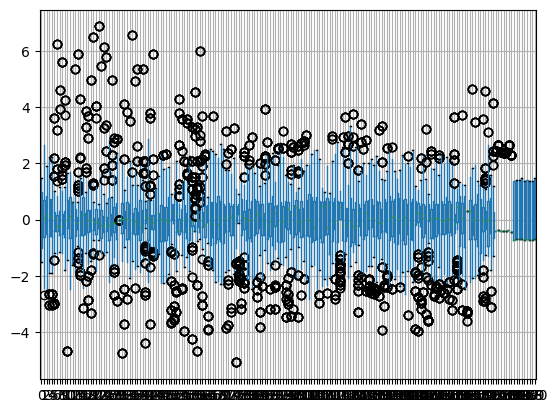

In [143]:
# _X_train.boxplot(figsize=(20,5))
pd.DataFrame(X_train).boxplot()
plt.show()

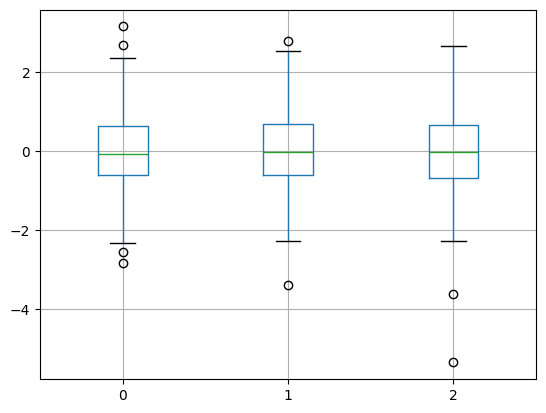

In [144]:
pd.DataFrame(Y_train).boxplot()
plt.show()

In [145]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR

# reg = MultiOutputRegressor(estimator=SVR(C=1))
# reg = MultiOutputRegressor(estimator=LinearRegression())
# reg = MultiOutputRegressor(
#     estimator=RandomForestRegressor(n_estimators=200, random_state=0)
# )
reg = MultiOutputRegressor(
    estimator=GradientBoostingRegressor(n_estimators=200, random_state=0, max_depth=5)
)

In [146]:
reg.fit(X_train, Y_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor(max_depth=5,
                                                         n_estimators=200,
                                                         random_state=0))

In [147]:
Y_train_pred = reg.predict(X_train)
Y_test_pred = reg.predict(X_test)

print(Y_train_pred.shape)
print(Y_test_pred.shape)

(264, 3)
(114, 3)


In [148]:
def eval_perf(y_true, y_pred):
    mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
    mape = mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    return mse, mape, r2


def print_perf(data):
    for k, v in data.items():
        print(k, ":", v)


data_arr = []
for i in range(0, _Y.shape[1]):
    mse_train, mape_train, r2_train = eval_perf(
        y_true=Y_train[:, i], y_pred=Y_train_pred[:, i]
    )
    mse_test, mape_test, r2_test = eval_perf(
        y_true=Y_test[:, i], y_pred=Y_test_pred[:, i]
    )

    data = {
        "Y": f"Y-{i + 1}",
        "MSE Train": mse_train,
        "MSE Test": mse_test,
        "MAPE Train": mape_train,
        "MAPE Test": mape_test,
        "R2 Train": r2_train,
        "R2 Test": r2_test,
    }
    # print_perf(data)

    data_arr.append(data)

mse_train, mape_train, r2_train = eval_perf(y_true=Y_train, y_pred=Y_train_pred)
mse_test, mape_test, r2_test = eval_perf(y_true=Y_test, y_pred=Y_test_pred)
print_perf(data)

data = {
    "Y": "Y-All",
    "MSE Train": mse_train,
    "MSE Test": mse_test,
    "MAPE Train": mape_train,
    "MAPE Test": mape_test,
    "R2 Train": r2_train,
    "R2 Test": r2_test,
}
data_arr.append(data)
# print_perf(data)

df_eval = pd.DataFrame.from_dict(data_arr)
display(df_eval)

if SAVE_DATA:
    filename = f"eval_{dt}.xlsx"
    df_eval.to_excel(filename, index=False)

Y : Y-3
MSE Train : 7.532336266098548e-05
MSE Test : 0.7453896767117223
MAPE Train : 0.03624416584764758
MAPE Test : 9.224573779652278
R2 Train : 0.999924676637339
R2 Test : 0.058721183646869735


,Y,MSE Train,MSE Test,MAPE Train,MAPE Test,R2 Train,R2 Test
0,Y-1,0.000140,0.902062,0.032991,2.063669,0.999860,-0.163966
1,Y-2,0.000835,1.450586,0.125155,9.298989,0.999165,-0.322163
2,Y-3,0.000075,0.745390,0.036244,9.224574,0.999925,0.058721
3,Y-All,0.000350,1.032679,0.064797,6.862411,0.999650,-0.142469


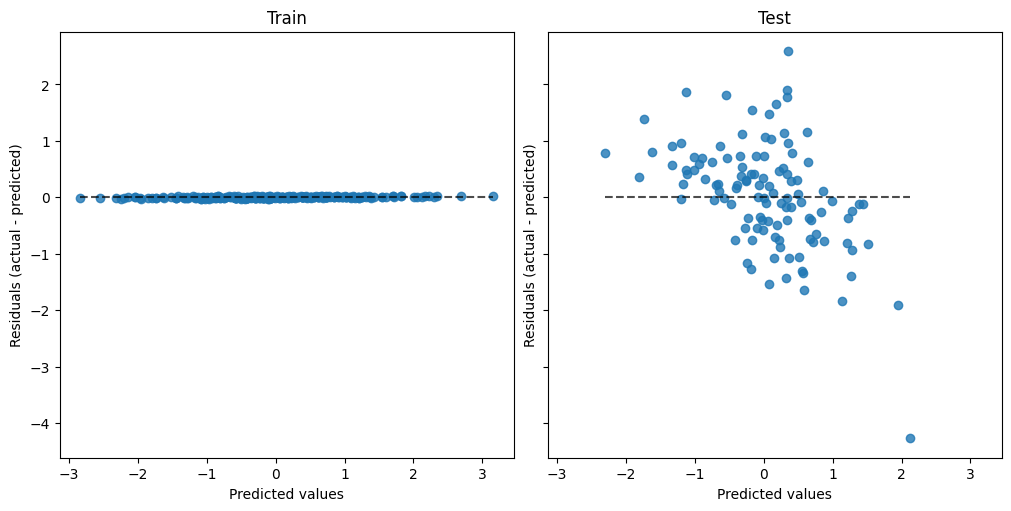

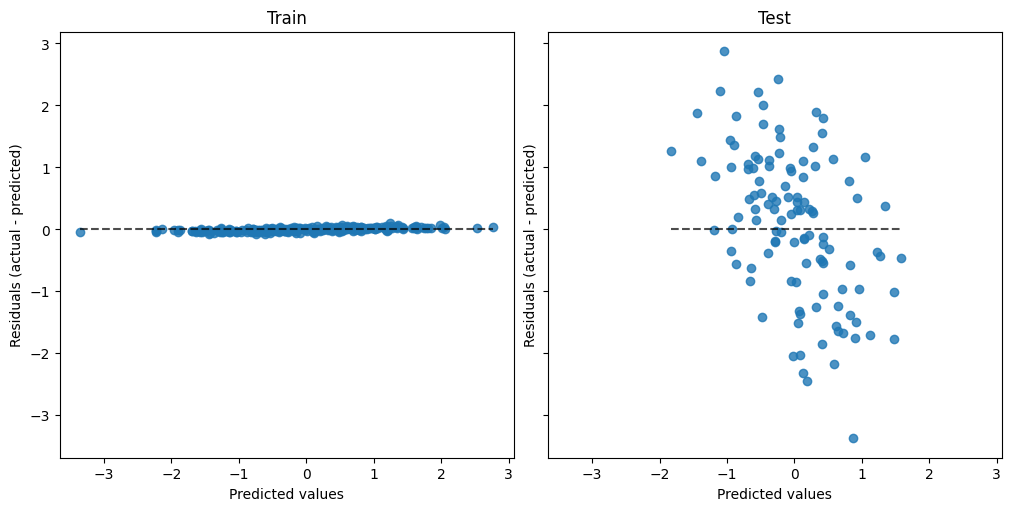

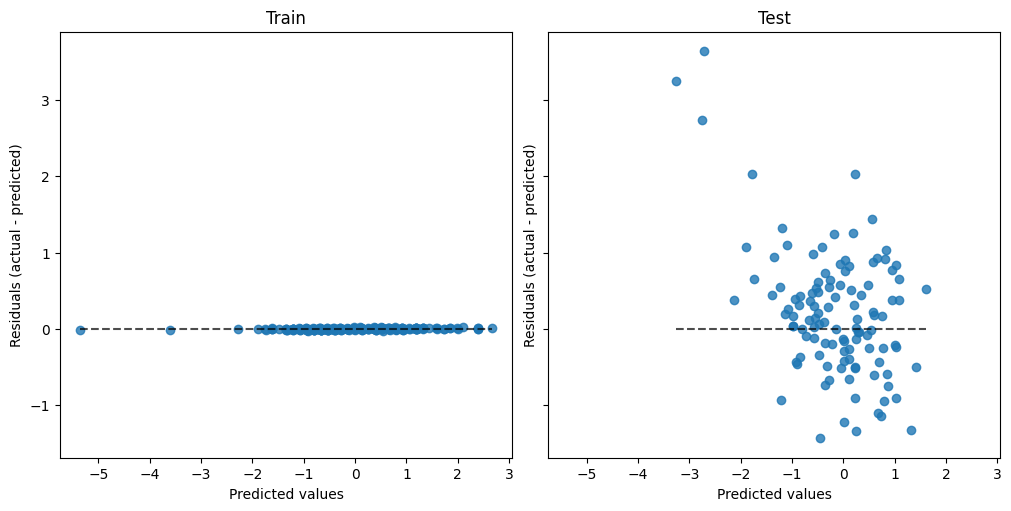

In [149]:
for i in range(0, _Y.shape[1]):
    fig, axes = plt.subplots(
        nrows=1,
        ncols=2,
        figsize=(10, 5),
        constrained_layout=True,
        sharex=True,
        sharey=True,
    )

    display_train = PredictionErrorDisplay(
        y_true=Y_train[:, i], y_pred=Y_train_pred[:, i]
    )
    display_train.plot(ax=axes[0])
    axes[0].set_title("Train")

    display_train = PredictionErrorDisplay(
        y_true=Y_test[:, i], y_pred=Y_test_pred[:, i]
    )
    display_train.plot(ax=axes[1])
    axes[1].set_title("Test")

    if SAVE_DATA:
        filename = f"res_plot_{dt}_{i}.png"
        fig.savefig(filename, dpi=300)

    plt.show()